For this week’s assignment we're going to use Dodgers Major League Baseball data from 2012. The data file you will be using is contained in the dodgers.csv file. I would like you to determine what night would be the best to run a marketing promotion to increase attendance. It is up to you if you decide to recommend a specific date or if you  recommend a day of the week (e.g., Tuesdays) or month and day of the week (e.g., July Tuesdays). Use R and/or Python to accomplish this assignment. It is important to remember, there will be lots of ways to solve this problem. Explain your thought process and how you used various techniques to come up with your recommendation.

### Reading in data

In [1387]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [1388]:
#dodgers.csv file
dodgers_pd = pd.read_csv("C:/Users/phill/OneDrive/Desktop/Predictive-630/data/dodgers.csv")
dodgers_pd.head()

,month,day,attend,day_of_week,opponent,temp,skies,day_night,cap,shirt,fireworks,bobblehead
0,APR,10,56000,Tuesday,Pirates,67,Clear,Day,NO,NO,NO,NO
1,APR,11,29729,Wednesday,Pirates,58,Cloudy,Night,NO,NO,NO,NO
2,APR,12,28328,Thursday,Pirates,57,Cloudy,Night,NO,NO,NO,NO
3,APR,13,31601,Friday,Padres,54,Cloudy,Night,NO,NO,YES,NO
4,APR,14,46549,Saturday,Padres,57,Cloudy,Night,NO,NO,NO,NO


### Identifying Missing Data

In [1389]:
#looking at the data when reviews.val.title is NULL --> empty review
dodgers_pd.isnull().sum()

month          0
day            0
attend         0
day_of_week    0
opponent       0
temp           0
skies          0
day_night      0
cap            0
shirt          0
fireworks      0
bobblehead     0
dtype: int64

There is no missing data in the DataFrame!!

### Building Promo Variable

In looking over the data and thinking about our problem statement, I wanted to build a derivative variable that denoted if any promotion was offered at a given Dodgers game. Our original dataset had a 'YES' or 'NO' marker for the various promotion items such as shirt, cap, etc. However, for the problem, I want to know plainly whether a promotion should be offered on a given day. Therefore, I just want a variable that marks the records with games that offered promotions or did not offer promotions.

In [1390]:
#function to determine if a promotion was overall offered at a Dodgers game
def mark_promo(df):
    #if any 'YES' values among the promotions, assign a 'YES' for the new column
    if df['cap'] == 'YES' or df['shirt'] == 'YES' or df['fireworks'] == 'YES' or df['bobblehead'] == 'YES':
        df['promo'] = 'YES'
    #no 'YES' assign 'NO'
    else:
        df['promo'] = 'NO'
    return df

In [1391]:
#apply the mark_promo function to the dataframe to create the new 'promo column'
dodgers_pd = dodgers_pd.apply(mark_promo,axis=1)

### Creating Promo & Day of Week Interaction Term

Similar to above, as related to the problem statement, now that we have a marker for games with and without promotions. I also want to explore the interaction between day of the week and offering a promotion. Therefore, I want to create a new column with those possibilities of day of the week and promotion offering to explore in the regression modeling.

In [1392]:
#creating a new column 'day_promo'
#created out of the current 'day_of_week' and 'promo' variables
dodgers_pd['day_promo'] = dodgers_pd['day_of_week'] + dodgers_pd['promo']

In [1393]:
dodgers_pd['day_promo'].head()

0      TuesdayNO
1    WednesdayNO
2     ThursdayNO
3      FridayYES
4     SaturdayNO
Name: day_promo, dtype: object

In [1394]:
dodgers_pd['day_promo'].value_counts()

FridayYES       13
MondayNO        11
SaturdayNO      11
WednesdayNO     11
SundayNO        10
TuesdayYES       8
TuesdayNO        5
SundayYES        3
ThursdayNO       3
ThursdayYES      2
SaturdayYES      2
WednesdayYES     1
MondayYES        1
Name: day_promo, dtype: int64

Friday games with promotions hold the maximum number of data values, with 13 out of 81 games. The other leading values are days where promotions weren't offered. Therefore, we will have to do some digging to see which days will bring the highest increase in attendance when promotions are given.

From looking initially at these value counts, one would think that promotions should be offered on Fridays as they have the highest representation in the dataset. However, what is the change in attendance that they bring?

### Descriptive Statistics

In [1395]:
#describing the overall dataframe

#retrieving rows and columns
print("The dimension of the table is: ",dodgers_pd.shape)
print("81 rows and 14 columns")

The dimension of the table is:  (81, 14)
81 rows and 14 columns


In [1396]:
dodgers_pd.dtypes

month          object
day             int64
attend          int64
day_of_week    object
opponent       object
temp            int64
skies          object
day_night      object
cap            object
shirt          object
fireworks      object
bobblehead     object
promo          object
day_promo      object
dtype: object

Numerical variables --> day, attend, temp


Categorical variables --> month, day_of_week, opponent, skies, day_night, cap, shirt, fireworks, bobblehead,day_promo, promo

### Describing the Date/Time Variables

In [1397]:
#looking at date features for prediction
dates_targets = dodgers_pd[['month','day','day_of_week','day_night']]
dates_targets

,month,day,day_of_week,day_night
0,APR,10,Tuesday,Day
1,APR,11,Wednesday,Night
2,APR,12,Thursday,Night
3,APR,13,Friday,Night
4,APR,14,Saturday,Night
...,...,...,...,...
76,SEP,29,Saturday,Night
77,SEP,30,Sunday,Day
78,OCT,1,Monday,Night
79,OCT,2,Tuesday,Night


In [1398]:
#describe the data
desc = dates_targets.describe()
desc

,day
count,81.000000
mean,16.135802
std,9.605666
min,1.000000
25%,8.000000
50%,15.000000
75%,25.000000
max,31.000000


This result shows the summary statistics for the 'day' variable in the dataset, which just marks the day of the month for the corresponding Dodgers MLB game. Given that there are usually around 30-31 days in a month, these statistics don't give us very much information around the target variable. This variable will be more useful when combined with the other date/time variables!

In [1399]:
dates_targets['day_night'].value_counts()

Night    66
Day      15
Name: day_night, dtype: int64

C:\Users\phill\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Boxplot of Game Days in a Month')

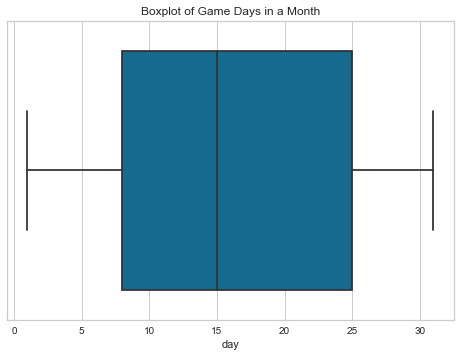

In [1400]:
#boxplot of 'day'
sns.boxplot(dates_targets['day'])
plt.title("Boxplot of Game Days in a Month")

Text(0, 0.5, 'Attendance')

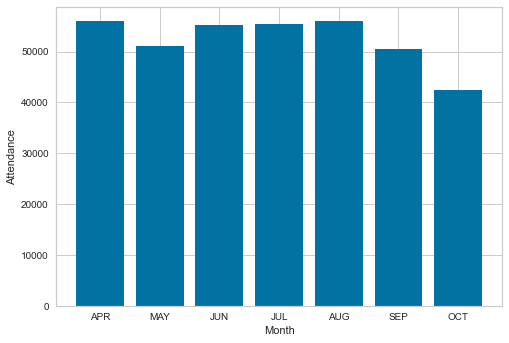

In [1401]:
#bar graph visualization for attendance counts per month
plt.bar(dodgers_pd['month'],dodgers_pd['attend'])
plt.xlabel('Month')
plt.ylabel('Attendance')

Text(0, 0.5, 'Attendance')

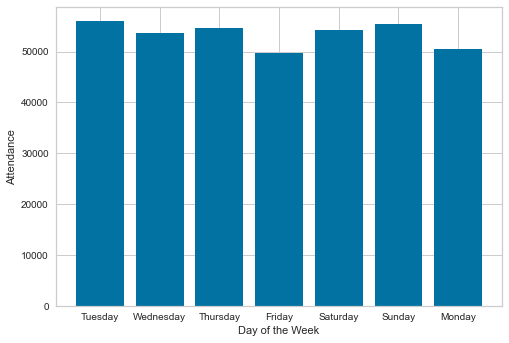

In [1402]:
#bar graph visualization for attendance counts for day of the week
plt.bar(dodgers_pd['day_of_week'],dodgers_pd['attend'])
plt.xlabel('Day of the Week')
plt.ylabel('Attendance')

Just from visualizing the other potential target variables of 'month', 'day_of_week' and 'day_night', it can be seen where most of the values in the dataset lie. The months as per the baseball seasion fall during summer and fall with the majority of games being in May and August. Also, with the days of the week, most of the games are held during the weekend from Friday to Sunday, with Tuesday being a weekday that holds majority popularity. Also, night games are much more popular than day games ... these classes are imbalanced. 

The boxplot of 'day' is not uniform or normal; it has three peaks at the beginning of the months (~1-3), middle of the months (~day 15), and the end of the months (~29-31). It could be that each baseball season has a different schedule, so I'm not sure there is much significance to the frequency of the days during a month that are played and attended, since it depends on other teams and availability of sporting venues. 

As we are trying to gather results in relation to running a marketing promotion on a certain night in order to increase attendance, I am going to use 'month' and 'day_of_week' variables as the target variables for my regression since I think they will be the most influential in being able to provide valuable information around targeted marketing. Also, with marketing promotions especially in social media, it is more applicable to know a month and day of the week rather than just a day which can vary month to month. 

### Describing the Other Features

In [1403]:
features = dodgers_pd[['attend','opponent','temp','skies','cap','shirt','fireworks','bobblehead','promo']]
features

,attend,opponent,temp,skies,cap,shirt,fireworks,bobblehead,promo
0,56000,Pirates,67,Clear,NO,NO,NO,NO,NO
1,29729,Pirates,58,Cloudy,NO,NO,NO,NO,NO
2,28328,Pirates,57,Cloudy,NO,NO,NO,NO,NO
3,31601,Padres,54,Cloudy,NO,NO,YES,NO,YES
4,46549,Padres,57,Cloudy,NO,NO,NO,NO,NO
...,...,...,...,...,...,...,...,...,...
76,40724,Rockies,84,Cloudy,NO,NO,NO,NO,NO
77,35607,Rockies,95,Clear,NO,NO,NO,NO,NO
78,33624,Giants,86,Clear,NO,NO,NO,NO,NO
79,42473,Giants,83,Clear,NO,NO,NO,NO,NO


In [1404]:
desc_features = features.describe()
desc_features

,attend,temp
count,81.000000,81.000000
mean,41040.074074,73.148148
std,8297.539460,8.317318
min,24312.000000,54.000000
25%,34493.000000,67.000000
50%,40284.000000,73.000000
75%,46588.000000,79.000000
max,56000.000000,95.000000


C:\Users\phill\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, "Boxplot of Dodgers Games' Attendance")

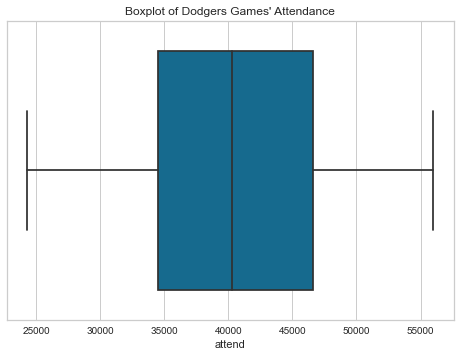

In [1405]:
#boxplot of 'attend'
sns.boxplot(features['attend'])

plt.title("Boxplot of Dodgers Games' Attendance")

C:\Users\phill\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Boxplot of Temperature at Dodgers Games')

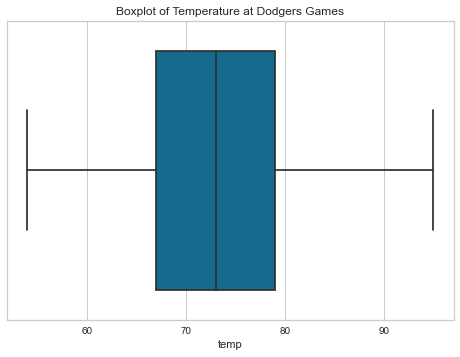

In [1406]:
#boxplot of 'temp'
sns.boxplot(features['temp'])

plt.title("Boxplot of Temperature at Dodgers Games")

The distribution for 'attend' is neither normal nor uniform. It is more right-skewed, but there is lower frequency at the higher-end of the attendance counts after the peak around ~45,000 people. It is more rare for there to be more than 45,000 people in attendance at the games, and those higher counts could be due to special events or holidays such as the 4th of July. 

The distribution of game temperatures is relatively normal! The concentration of temperatures are around 70-75 degrees Fahrenheit, which makes sense given the months that the games are held during. Summer to fall seasons range around mildly warm and hot temperatures, so this distribution makes sense with that weather. 

Giants       9
Rockies      9
Padres       9
Snakes       9
Cardinals    7
Mets         4
Brewers      4
Angels       3
Reds         3
Nationals    3
White Sox    3
Marlins      3
Phillies     3
Braves       3
Cubs         3
Pirates      3
Astros       3
Name: opponent, dtype: int64


<AxesSubplot:>

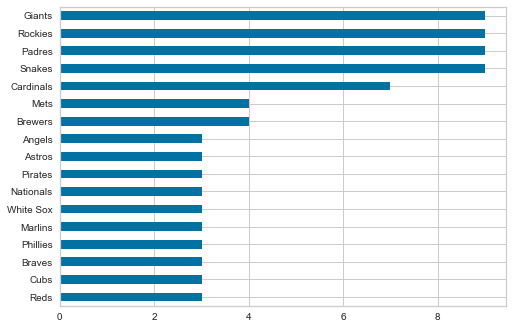

In [1407]:
#value counts for categorical variables
print(features['opponent'].value_counts())
features['opponent'].value_counts().sort_values().plot(kind = 'barh')

In [1408]:
print(features['skies'].value_counts())

Clear     62
Cloudy    19
Name: skies, dtype: int64


In [1409]:
print(features['cap'].value_counts())

NO     79
YES     2
Name: cap, dtype: int64


In [1410]:
print(features['shirt'].value_counts())

NO     78
YES     3
Name: shirt, dtype: int64


In [1411]:
print(features['fireworks'].value_counts())

NO     67
YES    14
Name: fireworks, dtype: int64


In [1412]:
print(features['bobblehead'].value_counts())

NO     70
YES    11
Name: bobblehead, dtype: int64


In [1413]:
print(features['promo'].value_counts())

NO     51
YES    30
Name: promo, dtype: int64


The balance for the categorical variables with 'skies', 'cap', 'shirt', 'fireworks' and 'bobblehead' is quite imbalanced. There is a value that holds the majority, which would need to be handled when going into regression modeling. Most of these are in correspondence to promotional objects, and it seems that 'NO' is the majority value which shows that the past promotion items were not so popularly taken at the baseball games. 

Out of the 81 Dodgers games in the dataset, some sort of promotion was offered at 30 of them ... a little less than half. There is a higher amount where no promotions were offered, but it allow us to compare the days where promotions were and weren't offered and anaylze the change on attendance in comparison.

### Creating Label Encoders for Categorical Variables

In order to utilize categorical variables in our models, we need to encode them as numbers. The pieces of code below do exactly this!

In [1414]:
#month, day_of_week, opponent, skies, day_night, cap, shirt, fireworks, bobblehead
cat_cols = ['month','day_of_week','opponent','skies','day_night','cap','shirt','fireworks','bobblehead','promo','day_promo']

#turning categories into their numerical counterparts using LabelEncoder
for var in cat_cols:
    number = LabelEncoder()
    dodgers_pd[var+"cat"] = number.fit_transform(dodgers_pd[var].astype('str'))

In [1415]:
dodgers_pd.head()

,month,day,attend,day_of_week,opponent,temp,skies,day_night,cap,shirt,...,day_of_weekcat,opponentcat,skiescat,day_nightcat,capcat,shirtcat,fireworkscat,bobbleheadcat,promocat,day_promocat
0,APR,10,56000,Tuesday,Pirates,67,Clear,Day,NO,NO,...,5,12,0,0,0,0,0,0,0,9
1,APR,11,29729,Wednesday,Pirates,58,Cloudy,Night,NO,NO,...,6,12,1,1,0,0,0,0,0,11
2,APR,12,28328,Thursday,Pirates,57,Cloudy,Night,NO,NO,...,4,12,1,1,0,0,0,0,0,7
3,APR,13,31601,Friday,Padres,54,Cloudy,Night,NO,NO,...,0,10,1,1,0,0,1,0,1,0
4,APR,14,46549,Saturday,Padres,57,Cloudy,Night,NO,NO,...,2,10,1,1,0,0,0,0,0,3


In [1416]:
print(dodgers_pd['month'].value_counts())
print(dodgers_pd['monthcat'].value_counts())

MAY    18
AUG    15
APR    12
JUL    12
SEP    12
JUN     9
OCT     3
Name: month, dtype: int64
4    18
1    15
0    12
2    12
6    12
3     9
5     3
Name: monthcat, dtype: int64


-----------------MONTH CATEGORIES-----------------

4: MAY

1: AUG

0: APR

2: JUL

6: SEP

3: JUN

5: OCT

In [1417]:
print(dodgers_pd['day_of_week'].value_counts())
print(dodgers_pd['day_of_weekcat'].value_counts())

Saturday     13
Tuesday      13
Sunday       13
Friday       13
Monday       12
Wednesday    12
Thursday      5
Name: day_of_week, dtype: int64
0    13
2    13
3    13
5    13
1    12
6    12
4     5
Name: day_of_weekcat, dtype: int64


-----------------DAY OF WEEK CATEGORIES-----------------

0: Saturday

2: Tuesday

3: Sunday

5: Friday

1: Monday

6: Wednesday

4: Thursday

---------PROMOTION CATEGORIES------------------

0: NO

1: YES

In [1418]:
print(dodgers_pd['day_promo'].value_counts())
print(dodgers_pd['day_promocat'].value_counts())

FridayYES       13
MondayNO        11
SaturdayNO      11
WednesdayNO     11
SundayNO        10
TuesdayYES       8
TuesdayNO        5
SundayYES        3
ThursdayNO       3
ThursdayYES      2
SaturdayYES      2
WednesdayYES     1
MondayYES        1
Name: day_promo, dtype: int64
0     13
1     11
3     11
11    11
5     10
10     8
9      5
6      3
7      3
4      2
8      2
2      1
12     1
Name: day_promocat, dtype: int64


### Investigating Relationships between Variables

We want to explore the correlation between our features to ensure that we are not performing modeling on features which have a relationship and therefore an effect on each other. In regression, we purely want to see which features have an effect on our predictor variable, and by removing highly-correlated features or ones with multicollinearity, we can ensure that our features will represent the effect on the dependent variable and not on eachother.

In [1419]:
#correlation plot
dodgers_pd_regress = dodgers_pd.copy()

print(dodgers_pd_regress.columns)

Index(['month', 'day', 'attend', 'day_of_week', 'opponent', 'temp', 'skies',
       'day_night', 'cap', 'shirt', 'fireworks', 'bobblehead', 'promo',
       'day_promo', 'monthcat', 'day_of_weekcat', 'opponentcat', 'skiescat',
       'day_nightcat', 'capcat', 'shirtcat', 'fireworkscat', 'bobbleheadcat',
       'promocat', 'day_promocat'],
      dtype='object')


In [1420]:
#creating new dataframe with only needed columns for regression
dodgers_pd_regress = dodgers_pd_regress[['day','monthcat','day_of_weekcat','opponentcat','skiescat','day_nightcat','capcat','shirtcat','fireworkscat','bobbleheadcat','attend','temp','day_promocat','promocat']]

In [1421]:
#subset dataframe to only have night games --> where day_nightcat = 1
dodgers_pd_regress = dodgers_pd_regress[dodgers_pd_regress['day_nightcat']==1]

In [1422]:
#drop day_nightcat column after only using 'Night'
dodgers_pd_regress = dodgers_pd_regress.drop(['day_nightcat'],axis=1)

In [1423]:
print(dodgers_pd_regress.shape)
print("66 rows and 13 columns for Dodgers Night Games")

(66, 13)
66 rows and 13 columns for Dodgers Night Games


In [1424]:
corr = dodgers_pd_regress.corr()
corr.style.background_gradient(cmap='coolwarm')

,day,monthcat,day_of_weekcat,opponentcat,skiescat,capcat,shirtcat,fireworkscat,bobbleheadcat,attend,temp,day_promocat,promocat
day,1.000000,-0.183142,-0.125346,-0.130097,-0.039875,-0.168428,-0.156662,0.122905,0.172594,0.018145,-0.178982,-0.112006,0.135843
monthcat,-0.183142,1.000000,-0.017610,-0.093765,-0.171474,-0.052585,0.154053,-0.047138,-0.168530,-0.082841,0.473551,-0.032374,-0.125638
day_of_weekcat,-0.125346,-0.017610,1.000000,-0.097733,0.130012,0.127088,0.019582,-0.552176,0.272458,0.154318,0.079533,0.993672,-0.213091
opponentcat,-0.130097,-0.093765,-0.097733,1.000000,-0.114155,0.119136,-0.125112,0.096491,0.090432,0.000970,0.116211,-0.084097,0.134058
skiescat,-0.039875,-0.171474,0.130012,-0.114155,1.000000,0.202548,-0.108253,-0.068088,-0.091287,-0.154587,-0.331492,0.119425,-0.112641
capcat,-0.168428,-0.052585,0.127088,0.119136,0.202548,1.000000,-0.021926,-0.064358,-0.055470,-0.102093,-0.032427,0.146009,0.144496
shirtcat,-0.156662,0.154053,0.019582,-0.125112,-0.108253,-0.021926,1.000000,-0.091725,-0.079057,0.098326,0.020578,0.043613,0.205939
fireworkscat,0.122905,-0.047138,-0.552176,0.096491,-0.068088,-0.064358,-0.091725,1.000000,-0.232048,0.012777,-0.154326,-0.492717,0.604471
bobbleheadcat,0.172594,-0.168530,0.272458,0.090432,-0.091287,-0.055470,-0.079057,-0.232048,1.000000,0.646926,0.118626,0.337303,0.520988
attend,0.018145,-0.082841,0.154318,0.000970,-0.154587,-0.102093,0.098326,0.012777,0.646926,1.000000,0.208329,0.215438,0.507261


High correlations:
1. attend & bobbleheadcat are relatively highly correlated with one another as features: 0.646926
2. temp is also highly correlated with our target values of monthcat & month_day_weekcat: 0.473551 and 0.458327 respectively
3. fireworkscat and promocat are correlated at 0.604471 --> relatively positive relationship
4. bobbleheadcat and promocat have a correlation of 0.520988
5. promocat & attend also have a higher positive correlation of 0.507261

#### Scatterplots for Correlation Analysis

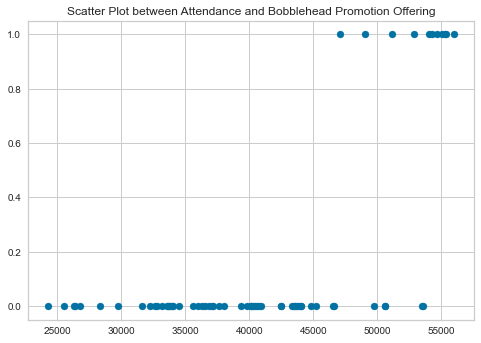

In [1425]:
#scatterplot between attend and bobbleheadcat
plt.scatter(dodgers_pd_regress['attend'], dodgers_pd_regress['bobbleheadcat'])
plt.title('Scatter Plot between Attendance and Bobblehead Promotion Offering')
plt.show()

As the game attendance increases, it seems that the probability for a bobblehead to be offered increases as well. Bobbleheads seem to be given out more when game attendance is higher. This goes along with the 0.646926 positive correlation from the correlation heat map. 

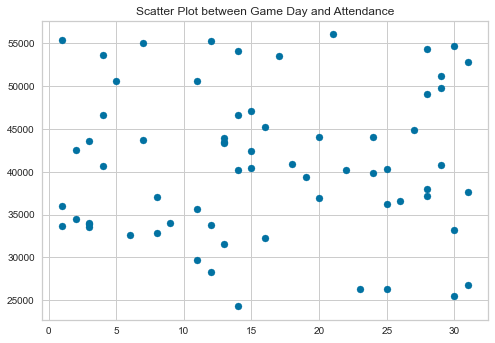

In [1426]:
#scatter plot between day and attend
plt.scatter(dodgers_pd_regress['day'], dodgers_pd_regress['attend'])
plt.title('Scatter Plot between Game Day and Attendance')
plt.show()

I wanted to visualize a scatter plot between two of the continuous variables in our dataset: day and attend. Day provides information around what day on a given month a Dodgers game is played.

It seems there is little to no relationship between these two variables, as also shown by their 0.0181 correlation value. This value is extremely close to zero, which signifies a neutral relationship where the variables do not have an effect on eachother. Given that a part of our problem is in relation to which day should be recommended in order to increase attendance, it looks like 'day' by itself may not have a significant impact on change in attendance at Dodgers games. 

#### Using VIF for feature reduction

VIF or Variance-Inflation Factor will determine if collinearity exists among variables. In the below function, our bounday for feature removal based on VIF is set to 5.0, which would define whether any features are correlated with each other. 

In [1427]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
#features --> all variables except for day_promocat
x=dodgers_pd_regress.drop(['day_promocat'],axis=1)
#target variable --> day_promocat
y= dodgers_pd_regress['day_promocat']

In [1428]:
#function for calculating the VIF score for each feature to determine if collinearity exists among variable
#finding values with large absolute values greater than 5
#function from https://medium.com/analytics-vidhya/feature-selection-techniques-2614b3b7efcd
def cal_vif(x):
    #threshold for VIF score
    thresh = 5
    output = pd.DataFrame()
    #number of columns
    k = x.shape[1]
    #calculate the VIF for the values in each column in the features
    vif = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
    for i in range(1,k):
        print('Iteration no ',i)
        print(vif)
        #determine the feature with max VIF
        a = np.argmax(vif)
        print('Max vif is for variable no : ',a)
        #if max is not less than the threshold of 5.0, break and keep looking
        if(vif[a]<=thresh):
            break
        #else drop features and keep searching ... recursive
        if(i==1):
            output=x.drop(x.columns[a],axis=1)
            vif = [variance_inflation_factor(output.values,j)for j in range(output.shape[1])]
        elif(i>1):
            output = output.drop(output.columns[a],axis=1)
            vif = [variance_inflation_factor(output.values,j) for j in range(output.shape[1])]
    return(output)

In [1429]:
selected_features = cal_vif(x)
selected_features.head()

Iteration no  1
[4.061312572851412, 4.440967980742168, 4.020726635483109, 4.6543308944975195, 1.5021032201139872, inf, inf, inf, inf, 44.87762739550238, 56.39769369240696, inf]
Max vif is for variable no :  5
Iteration no  2
[4.061312572851412, 4.440967980742171, 4.020726635483109, 4.6543308944975195, 1.5021032201139872, 3.471238666243197, 18.174001632740552, 14.755203310198624, 44.87762739550238, 56.39769369240696, 31.61817261330915]
Max vif is for variable no :  9
Iteration no  3
[3.6792483491802526, 3.208545439449354, 3.9473741062305168, 3.87554666175938, 1.5020772040947643, 3.4203576096258073, 17.96551450431619, 13.895680620270461, 14.787379179442071, 31.526122266182337]
Max vif is for variable no :  9
Iteration no  4
[3.6255014792201257, 3.206155530071861, 3.8940574456582526, 3.77463521062613, 1.4481700097883912, 1.1554482029507003, 2.048617746464274, 1.8419859675485437, 14.743780421072724]
Max vif is for variable no :  8
Iteration no  5
[2.9003642182051856, 2.559158968170141, 3.0

C:\Users\phill\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,day,monthcat,day_of_weekcat,opponentcat,skiescat,shirtcat,fireworkscat,bobbleheadcat
1,11,0,6,12,1,0,0,0
2,12,0,4,12,1,0,0,0
3,13,0,0,10,1,0,1,0
4,14,0,2,10,1,0,0,0
6,23,0,1,2,1,0,0,0


By utilizing the VIF of the variables, we were able to remove/drop variables which had collinearity with each other. The importance of dropping these allows for us to have features which provide unique and indepentent information about the variance within the given dataset. 

Through these iterations, the following features were dropped: attend, capcat, promocat, temp.

### Multinomial Logistic Regression

Now that our features have been selected by looking into correlation and VIF, we are ready to apply a regression model to predict our target variable 'day_promocat'. This is a categorical variable which represents the days of the week as numbers; therfore, our options for a model are a multinomial logistic regression model as we have a multinomial categorical dependent variable.

In choosing a Multinomial Logistic Regression model, I envisioned the business users plugging in values for the features and being able to receive an output which lets them know the day of the week and whether a promotion should be offered that day. It is more brute-force though, and not as predictive as the linear regression model later in this report. 

In [1430]:
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split

In [1431]:
#split the dataset into training and test sets --> 75:25
#25% for testing
X_train,X_test,y_train,y_test=train_test_split(selected_features,y,test_size=0.25,random_state=0)

In [1432]:
# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=1000)

In [1433]:
# fit the model with data
model.fit(X_train,y_train)

#get predictions using test set of x's
y_pred=model.predict(X_test)

In [1434]:
model.coef_

array([[ 9.18791640e-02,  3.26532042e-02, -2.05745666e+00,
         1.15041307e-01,  9.91761301e-02, -4.56375893e-02,
         1.56181498e+00, -1.16020663e-01],
       [ 5.67699516e-02, -4.55904450e-02, -1.38473781e+00,
         1.41981845e-01, -5.99118761e-01, -1.13503841e-01,
        -8.73537411e-01, -4.91364566e-01],
       [-1.48991071e-01,  1.01662684e-02, -5.21783368e-01,
        -8.09714548e-01, -1.62424323e-01,  2.79461005e-01,
        -3.67096677e-02, -8.21892964e-02],
       [ 2.11612053e-02,  3.74917148e-01, -5.52786016e-01,
         1.11660541e-01,  1.20294281e+00, -1.59037219e-01,
        -4.49620281e-01, -4.59768710e-01],
       [ 1.05594577e-01, -4.71888162e-01, -4.93030067e-01,
         1.35823723e-01, -3.55341120e-01, -7.43716513e-03,
        -1.08120557e-01,  8.64269314e-01],
       [ 6.80420074e-02,  1.74763777e-01, -1.56806043e-02,
        -1.33806086e-01, -2.03150700e-01, -3.17193478e-02,
        -2.17107634e-02, -1.34479585e-01],
       [-6.30423141e-01, -3.542961

### Model Evaluation

In [1435]:
# import the metrics class
from sklearn import metrics

#confusion matrix to evaluate the performance of the classification model
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[3, 0, 0, 0, 0, 0, 0],
       [0, 3, 2, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 1, 0, 0],
       [0, 0, 0, 0, 0, 3, 0],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int64)

In [1436]:
#evaluating the matrix using a heatmap
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 257.44, 'Predicted label')

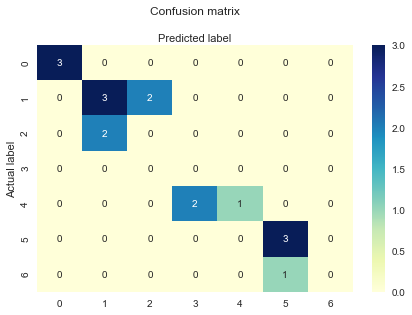

In [1437]:
class_names=[0,1,2,3,4,5,6,7,8,9,10,11,12] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap for the confusion matrix
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [1438]:
#metrics for confusion matrix evaluation
print(f'Classification Report: \n{metrics.classification_report(y_test, y_pred,labels=np.unique(y_pred))}')

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.60      0.60      0.60         5
           3       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         0
          10       1.00      0.33      0.50         3
          11       0.75      1.00      0.86         3

   micro avg       0.59      0.62      0.61        16
   macro avg       0.56      0.49      0.49        16
weighted avg       0.70      0.62      0.63        16



C:\Users\phill\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phill\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phill\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. If records are labeled with a certain day of week and promo, how many actually have these day and promo values? 
For the labels: 0,1,10 and 11, they have a precision greater than zero. Classes 0 & 10 have a precision of 1.00 which is suspicious and could be due to having greater representation in the dataset. Classes 1 & 11 have precision values of 0.60 and 0.75 respectively which is a relatively good percentage, and it lets us know that for MondayNO & WednesdayNO, they are correctly predicted 60% and 75% of the time from the model. 

These same classes have relatively high recall scores, except for 10 which represents TuesdayYES. Of all the games on Tuesdays with promotions, how many did we actually label? We only actually labeled 33% of them, which is not great as it is not over 50%. The model's recall for this label is not very reliable, which gives suspicious as to the model's ability to define this class and therefore games on Tuesdays with promotions.

In [1439]:
#using stratified k fold to handle imbalance in classes for our target variale

# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, selected_features, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

C:\Users\phill\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\phill\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\phill\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Mean Accuracy: 0.531 (0.102)


From proper analysis of the Multinomial Logistic Regression model results, I do not think it will be very helpful for giving guidance on our problem statement of deciding which day to run promotions in order to increase attendance.

It will allow for feature values to be defined in order to determine which day of the week a game is and whether promotion is offered on that day, but I don't think it will give clear information on which day of the week will increase attendance when a promotion is offered.

Therefore, I decided to utilize a linear regression model instead with 'attend' as our target variable to look into the change in attendance based on other predictors.

### Linear Regression

In [1440]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [1441]:
#copy of dataset of linear regression modelf
dodgers_pd_lr = dodgers_pd.copy()

print(dodgers_pd_lr.columns)

Index(['month', 'day', 'attend', 'day_of_week', 'opponent', 'temp', 'skies',
       'day_night', 'cap', 'shirt', 'fireworks', 'bobblehead', 'promo',
       'day_promo', 'monthcat', 'day_of_weekcat', 'opponentcat', 'skiescat',
       'day_nightcat', 'capcat', 'shirtcat', 'fireworkscat', 'bobbleheadcat',
       'promocat', 'day_promocat'],
      dtype='object')


In [1442]:
#looking at data types of our columns --> all wll need to be numeric for our model
dodgers_pd_lr.dtypes

month             object
day                int64
attend             int64
day_of_week       object
opponent          object
temp               int64
skies             object
day_night         object
cap               object
shirt             object
fireworks         object
bobblehead        object
promo             object
day_promo         object
monthcat           int32
day_of_weekcat     int32
opponentcat        int32
skiescat           int32
day_nightcat       int32
capcat             int32
shirtcat           int32
fireworkscat       int32
bobbleheadcat      int32
promocat           int32
day_promocat       int32
dtype: object

In [1443]:
#removing data for day-games
#subset dataframe to only have night games --> where day_nightcat = 1
dodgers_pd_lr = dodgers_pd_lr[dodgers_pd_lr['day_nightcat']==1]

In [1444]:
dodgers_pd_lr = dodgers_pd_lr.drop(['day_nightcat','day_night'],axis=1)

In [1445]:
#defined X = features and Y = target variable
X = dodgers_pd_lr[[ 'day', 'day_of_week','month', 'opponent', 'temp','skies','cap','shirt','fireworks','bobblehead','promo','day_promo']]
Y = dodgers_pd_lr[['attend']]

In [1446]:
#creating dummies for our categorical variables
#this function will create k-1 dummy variables for representation
X = pd.get_dummies(data=X, drop_first=True)
X.head()

,day,temp,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,month_AUG,month_JUL,...,day_promo_SaturdayNO,day_promo_SaturdayYES,day_promo_SundayNO,day_promo_SundayYES,day_promo_ThursdayNO,day_promo_ThursdayYES,day_promo_TuesdayNO,day_promo_TuesdayYES,day_promo_WednesdayNO,day_promo_WednesdayYES
1,11,58,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,12,57,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,13,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,14,57,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
6,23,60,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1447]:
#using VIF function to remove features with high collinearity
selected_features2 = cal_vif(X)
selected_features2.head()

C:\Users\phill\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Iteration no  1
[6.575135267426644, 12.971195573863799, inf, inf, inf, inf, inf, inf, 26.944617278797217, 18.71197390440583, inf, 18.635311301176845, 10.239888948839722, 22.1364400090354, inf, inf, inf, inf, inf, inf, inf, 5.092696939168191, inf, inf, inf, inf, inf, inf, inf, 2.5919457313108176, 5.403337057771748, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
Max vif is for variable no :  2
Iteration no  2
[6.5751352674266395, 12.971195573863799, inf, inf, inf, inf, inf, 26.944617278797217, 18.71197390440583, inf, 18.635311301176806, 10.239888948839722, 22.1364400090354, inf, inf, inf, inf, inf, inf, inf, 5.092696939168188, inf, inf, inf, inf, inf, inf, inf, 2.5919457313108194, 5.403337057771748, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
Max vif is for variable no :  2
Iteration no  3
[6.575135267426644, 12.97119557386378, inf, inf, inf, inf, 26.944617278797217, 18.71197390440583, inf, 18.635311301176845,

Iteration no  15
[3.492360980969639, 5.013767202887805, 1.847504762579911, 2.3608935039690047, 1.6043166023465132, 2.5593647334664356, 1.7397393515354824, 2.08738860379342, 1.9213454426103367, 3.647194117079607, 1.7453693726315727, 2.1510226074831604, 1.5033204164840526, 3.4143535901062014, 2.592593548697303, 2.011606064437333, 3.39687592147369, 1.9999201661995802, 2.3353637211544367, 1.1042496500636698, 5.820937182310944, 4.255948127653264, 2.744022911763135, 3.1279740638266316, 2.0849930012733986, 2.013281665936212, 1.3478981006322366, 2.1474414268264614, 1.7886790665650298, 1.7360602866217623, 2.252594434091885, 2.6809826368717564, 2.3575995742921383, 1.7122880805773657]
Max vif is for variable no :  20
Iteration no  16
[3.4211152352138847, 4.8691192186212096, 1.7284223725586076, 2.2945531459743242, 1.0959306217371967, 1.688107287586561, 1.6871875792432631, 2.0022763767054697, 1.7450539368193705, 3.633193371980791, 1.7450539368193705, 2.145423947803769, 1.437166234024457, 2.14793357

,month_AUG,month_JUL,month_OCT,month_SEP,opponent_Astros,opponent_Braves,opponent_Brewers,opponent_Cardinals,opponent_Cubs,opponent_Giants,...,day_promo_SaturdayNO,day_promo_SaturdayYES,day_promo_SundayNO,day_promo_SundayYES,day_promo_ThursdayNO,day_promo_ThursdayYES,day_promo_TuesdayNO,day_promo_TuesdayYES,day_promo_WednesdayNO,day_promo_WednesdayYES
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1448]:
#splitting data into training and test sets
#60/40 proportion
X_train2, X_test2, y_train2, y_test2 = train_test_split(selected_features2, Y, test_size=0.4, random_state=101)
print(X_train2.shape)
print(X_test2.shape)
print(y_train2.shape)
print(y_test2.shape)

(39, 33)
(27, 33)
(39, 1)
(27, 1)


In [1449]:
#fitting a Linear Regression model to our training set
model2 = LinearRegression()
model2.fit(X_train2,y_train2)

LinearRegression()

In [1450]:
# print the intercept
print(model2.intercept_)

[35755.30204866]


In [1451]:
#print the regression coefficients for our equation
model2.coef_

array([[ 3.60971004e+03,  3.45306208e+03,  5.21650420e+01,
         2.12307164e+03,  1.87883624e+02, -2.42515069e+02,
        -1.00993651e+04,  2.95081198e+03,  4.17198791e+03,
         1.15703654e+03, -3.86407461e+01,  1.40076980e+04,
         9.05169795e+03,  6.21227690e+03, -3.03599991e+03,
        -5.87936510e+03, -2.14410145e+04, -1.29586881e+03,
        -2.29350722e+03,  6.58688362e+03,  1.13686838e-12,
        -3.93436422e+03, -1.81898940e-12,  9.57628655e+02,
         9.43500000e+03, -1.81898940e-12, -4.54747351e-13,
         1.11706306e+03,  1.75494951e+04,  3.29879026e+03,
         1.61166504e+04, -1.46936945e+02,  0.00000000e+00]])

In [1452]:
#column names to show the features that were kept for the linear regression model
selected_features2.columns

Index(['month_AUG', 'month_JUL', 'month_OCT', 'month_SEP', 'opponent_Astros',
       'opponent_Braves', 'opponent_Brewers', 'opponent_Cardinals',
       'opponent_Cubs', 'opponent_Giants', 'opponent_Marlins', 'opponent_Mets',
       'opponent_Nationals', 'opponent_Padres', 'opponent_Phillies',
       'opponent_Pirates', 'opponent_Reds', 'opponent_Rockies',
       'opponent_Snakes', 'opponent_White Sox', 'shirt_YES',
       'day_promo_MondayNO', 'day_promo_MondayYES', 'day_promo_SaturdayNO',
       'day_promo_SaturdayYES', 'day_promo_SundayNO', 'day_promo_SundayYES',
       'day_promo_ThursdayNO', 'day_promo_ThursdayYES', 'day_promo_TuesdayNO',
       'day_promo_TuesdayYES', 'day_promo_WednesdayNO',
       'day_promo_WednesdayYES'],
      dtype='object')

In [1453]:
#make predictions from the test set and our model
predictions = model2.predict(X_test2)

C:\Users\phill\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='attend'>

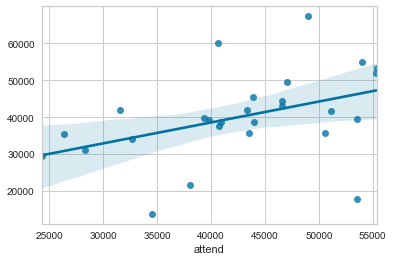

In [1454]:
#visualize the plot of actual vs. predicted 
sns.regplot(y_test2,predictions)

This plot visualizes the fit of our linear regression model, also with a 95% confidence interval band. There are many data points which do not fall along the regression model, which could show that there is another model which would better fit our data. However, it does look like there is a general linear trend. 

In [1455]:
import statsmodels.api as sm

#getting summary statistics for our linear regression model
X_train_Sm= sm.add_constant(X_train2)
X_train_Sm= sm.add_constant(X_train2)
ls=sm.OLS(y_train2,X_train_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:                 attend   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     2.549
Date:                Sat, 18 Dec 2021   Prob (F-statistic):             0.0526
Time:                        19:23:01   Log-Likelihood:                -367.42
No. Observations:                  39   AIC:                             790.8
Df Residuals:                      11   BIC:                             837.4
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   3.36

Friday 'day_promo' variables were removed from the features for the model. Therefore, how can we account for this day's effect on the attendance when there is or is not a promotion offered at the baseball game?

In [1456]:
#reading OLS summary from HTML to a DataFrame
summ_df = pd.read_html(ls.summary().tables[1].as_html(),header=0,index_col=0)[0]

In [1457]:
summ_df

,coef,std err,t,P>|t|,[0.025,0.975]
const,3.365000e+04,3.086770e+03,10.902,0.000,2.690000e+04,4.040000e+04
month_AUG,3.609710e+03,4.632813e+03,0.779,0.452,-6.587043e+03,1.380000e+04
month_JUL,3.453062e+03,1.080000e+04,0.320,0.755,-2.030000e+04,2.720000e+04
month_OCT,5.216500e+01,4.521874e+03,0.012,0.991,-9.900413e+03,1.000000e+04
month_SEP,2.123072e+03,5.558363e+03,0.382,0.710,-1.010000e+04,1.440000e+04
opponent_Astros,2.291137e+03,4.727089e+03,0.485,0.637,-8.113117e+03,1.270000e+04
opponent_Braves,1.860738e+03,6.964911e+03,0.267,0.794,-1.350000e+04,1.720000e+04
opponent_Brewers,-7.996112e+03,7.851580e+03,-1.018,0.330,-2.530000e+04,9.285099e+03
opponent_Cardinals,5.054065e+03,5.780424e+03,0.874,0.401,-7.668562e+03,1.780000e+04
opponent_Cubs,6.275241e+03,7.172613e+03,0.875,0.400,-9.511574e+03,2.210000e+04


In [1458]:
#finding difference between coefficients for each day of the week, isolating promotion effect'

#MONDAY
mon_no = summ_df['coef'].values[22] #MondayNO
mon_yes = summ_df['coef'].values[23]
print("Monday: " + str(mon_yes-mon_no))

Monday: 3934.364199999998


In [1459]:
#SATURDAY
sat_no = summ_df['coef'].values[24] #SaturdayNO
sat_yes = summ_df['coef'].values[25]
print("Saturday: " + str(sat_yes-sat_no))

Saturday: 8477.3713


In [1460]:
#SUNDAY
sun_no = summ_df['coef'].values[26] #SundayNO
sun_yes = summ_df['coef'].values[27]
print("Sunday: " + str(sun_yes-sun_no))

Sunday: -2.6562e-12


In [1461]:
#THURSDAY
thurs_no = summ_df['coef'].values[28] #ThursdayNO
thurs_yes = summ_df['coef'].values[29]
print("Thursday: " + str(thurs_yes-thurs_no))

Thursday: 16432.9369


In [1462]:
#TUESDAY
tues_no = summ_df['coef'].values[30] #TuesdayNO
tues_yes = summ_df['coef'].values[31]
print("Tuesday: " + str(tues_yes-tues_no))

Tuesday: 12821.2097


In [1463]:
#WEDNESDAY
wed_no = summ_df['coef'].values[32] #WednesdayNO
wed_yes = summ_df['coef'].values[33]
print("Wednesday: " + str(wed_yes-wed_no))

Wednesday: 146.9369


Although there are other features in the linear regression model, my focus is on the interaction parameters between day of the week and promotion offering (YES or NO). As the target variable is 'attend' or attendance, the parameter coefficients will allow us to determine the relationship between independent and dependent variables when holding the other parameters constant.

In terms of statistical significance at 0.1 (90%), the following two interaction parameters are significant: ThursdayYES & TuesdayYES at 0.041 and 0.051 respectively. If we are looking with a significance level of 95% or 0.05, the parameter that is statistically significant is ThursdayYES. With these significances, it indicates strong evidence against the null hypothesis. Therefore, we can reject the null hypothesis, and accept the alternative hypothesis that the parameters have a signifant relationship with our attendance target variable. 

Therefore, with TuesdayYES & ThursdayYES, if promotions are given on these days, the changes in attendance are both positive at 16,120 people & 17,550 people respectively. Both are relatively good increases in attendance, and would bring in a good population of people for the Dodgers!

However, in order to recommend one specific day to offer promotions at Dodgers games, I wanted to isolate the change that the promotion has on the attendance counts, given the day of the week. Therefore, I found the difference between each pair of interaction terms' coefficients such as ... MondayYES & MondayNO. 

*One note to account for is that I am not sure how to account for Fridays. In our dataset, for any Friday games, at least one promotion was offered at them. Therefore, when creating the dummy variables for the linear regression model, it removed the FridayYES variable since it did not have a counterpart. I was going to evaluate Friday as being the change in attendance when all other variables are set to zero, which would be equal to the y-intercept of 33,650. However, given the other features in the model, I am not sure if that is accurate to say. 

#### The day of the week which gave the greatest coefficient difference was Thursdays with a difference of 16,432.94 people. Therefore, I would recommend Thursdays as the best days to offer promotions at Dodgers games in order to increase attendance!